# Image Recoloring
**TODO:**


* Dataset class
* Training and test split
* Data augmentation (?)
* Model of generator and discriminator
* Loss function
* Traing procedure



## Setup




In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt                      
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files

import PIL


## Prepare dataset

The dataset is shared here https://drive.google.com/file/d/1Zq46n_VFuENm1OLaRaKQkIqq8wA__vFq/view?usp=sharing. Add a shortcut to your own google drive and mount drive on google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/COCOtrain2014.zip
!rm -rf /content/__MACOSX

ALby:


*   Classe dataset e dataloader
*   Resize a 256 x 256
* Bianco e nero 
* split train e test (80:20)






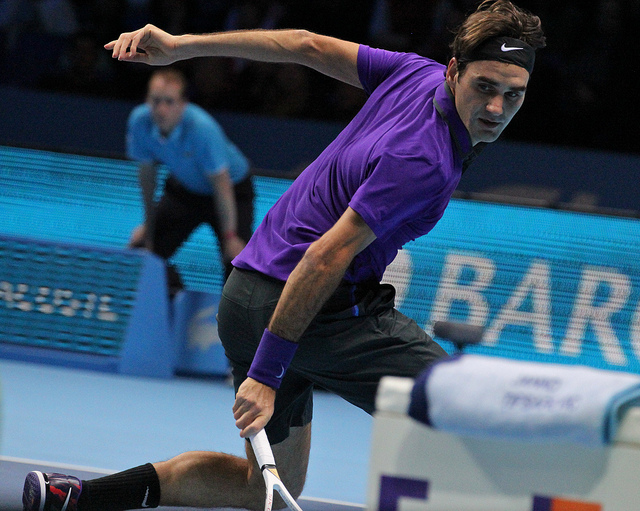

In [4]:
# to see if the dataset is working correctly
coco_path = '/content/COCOtrain2014'
dataset = get_image_files(coco_path)   
img = PIL.Image.open(dataset[1])
img

In [5]:
# basic info of the dataset
print("Dataset length: ", len(dataset))
print("Images dimensions: ", img.size)

Dataset length:  82783
Images dimensions:  (640, 511)


In [6]:
paths_list = glob.glob(coco_path+"/*.jpg")                              # paths_list is a list with all the image files names of our dataset
np.random.seed(123)                                                     # Seeding for reproducible results
paths_subset = np.random.choice(paths_list, 80000, replace=False)       # Randomly choosing 80000 images from the list
rand_indexes = np.random.permutation(80000)                             # Shuffling the indexes
train_indexes = rand_indexes[:60000]                                    # Using first 60000 images for training
test_indexes = rand_indexes[60000:]                                     # Using last 20000 images for testing
train_paths = paths_subset[train_indexes]                               # Array with all the image files names for the training
test_paths = paths_subset[test_indexes]                                 # Array with all the image files names for the test
print("Training set length: "+str(len(train_paths)))
print("Test set length: "+str(len(test_paths)))

Training set length: 60000
Test set length: 20000


## Dataset and Dataloader

In [7]:
SIZE = 256   # fixed size of the images 

class image_coloring_dataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
            ])
        elif split == 'test':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return L, ab     #{'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=os.cpu_count(), pin_memory=True, **kwargs): # function to make our dataloaders
    dataset = image_coloring_dataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [8]:
train_dl = make_dataloaders(paths=train_paths, split='train')
test_dl = make_dataloaders(paths=test_paths, split='test')

Ls, abs_ = next(iter(train_dl))
#Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(test_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
3750 1250


## Create the models

### Generator

In [24]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(64, 128, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(128, 256, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(256, 512, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(512, 512, down=True, act="leaky", use_dropout=False)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # U-Net decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        self.up1 = Block(512, 512, down=False, act="relu", use_dropout=True)
        self.up2 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.up3 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.up4 = Block(1024, 512, down=False, act="relu", use_dropout=False)
        self.up5 = Block(1024, 256, down=False, act="relu", use_dropout=False)
        self.up6 = Block(512, 128, down=False, act="relu", use_dropout=False)
        self.up7 = Block(256, 64, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, 2, kernel_size=4, stride=2, padding=1),   ## rimetti in_channels
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

def test():
    x = torch.randn((1, 1, 256, 256))
    model = Generator(in_channels=1)
    preds = model(x)
    print(model)
    print(preds.shape)

In [ ]:
test()

### Discriminator
The architecture for the PatchGAN Discriminator (70x70 patch) is:
 

1.   Convolutional layer with 64 filters, kernel size=4, stride=2, padding=1, LeakyRelu (with negative_slope=0.2)
2.   Convolutional layer with 128 filters, kernel size=4 stride=2, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization
3.   Convolutional layer with 256 filters, kernel size=4 stride=2, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization
4.   Convolutional layer with 512 filters, kernel size=4 stride=1, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization


In [11]:
class CNNBlockBN(nn.Module):
  def __init__(self, in_channels, out_channels, s=2):

    super().__init__()
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride=s, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.conv(x)

# CNN without Batch Normalization
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, s=2):

    super().__init__()
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride=s, padding=1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    features = [64, 128, 256, 512]

    self.model = nn.Sequential(
        CNNBlock(1+2, features[0]),    #*2 two image concatenated 
        CNNBlockBN(features[0], features[1]),
        CNNBlockBN(features[1], features[2]),
        # last block with stride = 1
        CNNBlockBN(features[2], features[3], s=1),
        nn.Conv2d(features[3], 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
    )
  
  def forward(self, x, y):
    x = torch.cat([x, y], dim=1)
    x = self.model(x)
    return x

In [ ]:
# test the model 
def test():
  # 1 image with 3 channels 256x256
  x = torch.randn((1, 1, 256, 256))
  y = torch.randn((1, 2, 256, 256))
  model = Discriminator()
  preds = model(x, y)
  print(model)
  print(preds.shape)

test()

Weights initialization

In [13]:
def initialize_weights(model, init="normal"):
    classname = model.__class__.__name__
    if classname.find('Conv2d') != -1:
        if(init=="xavier"): 
          nn.init.xavier_uniform_(model.weight.data)
        if(init=="normal"):
          nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0)

## Training

###Utility functions

In [38]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [42]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [40]:
def show_some_examples(gen, val_loader, epoch):
  #TODO
  x, y = next(iter(val_loader))
  x, y = x.to(device), y.to(device)
  gen.eval()
  with torch.no_grad():
    
    y_fake = gen(x)
    '''
    y_fake = y_fake * 0.5 + 0.5  # remove normalization#
    save_image(y_fake, folder + f"/y_gen_{epoch}.png")
    save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
    if epoch == 1:
      save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    '''
    plt.imshow(y_fake)
    plt.show()
  gen.train()


###Train loop

Hyper parameters (see paper)

In [43]:
L1_LAMBDA = 100
NUM_EPOCHS= 100
BATCH_SIZE = 16    # sul video è 16; paper è 4 (o da 1 a 10)
LR=0.0002 
BETA1=0.5
BETA2=0.999
LOAD_MODEL = True
CHECKPOINT_GEN = "disc.pth.tar"
CHECKPOINT_DISC = "gen.pth.tar"

In [44]:
if torch.cuda.is_available():
  print('GPU availble')
  # Define the device (here you can select which GPU to use if more than 1)
  device = torch.device("cuda")
else:
  print('GPU not availble')
  device = torch.device("cpu")

GPU availble


In [45]:
def train_loop():
    disc = Discriminator()
    gen = Generator(in_channels=1)
    if not LOAD_MODEL:
      print('Initializing the weights...')
      disc.apply(initialize_weights)
      gen.apply(initialize_weights)
    disc.to(device)
    gen.to(device)

    opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(BETA1, BETA2))
    opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(BETA1, BETA2))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    # Load the model 
    if LOAD_MODEL:
        print('Loading the model from the last checkpoint...')
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LR)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LR)

    # Load training set
    train_dataset = image_coloring_dataset(paths=train_paths, split='train')
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count(),
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    # Load validation set 
    val_dataset = image_coloring_dataset(paths=test_paths, split='test')     # fare un altro slit con val
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        training_step(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

        # Save weights
        #if epoch % 5 == 0:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)


        show_some_examples(gen, val_loader, epoch)


In [46]:
def training_step(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(device)    # BW image
        #print("Shape x: ", x.shape)
        y = y.to(device)    # original image
        #print("Shape y: ", y.shape)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # To show the loss
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


In [ ]:
train_loop()